# 2. MLP基礎
## 概要
本演習ではChapter02で学習した、深層学習の基礎である多層パーセプトロンを穴埋め形式で実装します。<br>
予め用意されたコード（訓練用・テスト用データの取得、ミニバッチ学習など）はそのまま使用し、指示された穴埋め部（順伝播と誤差逆伝播）を編集してください。<br>
演習問題文は<font color="Red">赤字</font>で表示されています。<br>このファイルは必ず最後までコードをすべて実行し、「最後までコードが実行可能」・「学習結果の出力がある」・「学習が成功している」の３つを満たした状態で提出してください。

所要時間：3~5時間

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [1]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install opencv-python==4.5.5.62
else:
    print("Not Google Colab")

Not Google Colab


### 【Google colabのみ実行】ドライブのマウント

Google Colabでは、**マウント**という作業を行って、Googleドライブ内のファイルを操作できる状態にする必要があります。<br>
<br>
以下のコードを実行してマウントしてください。なお、認証で**Googleアカウントへのログインが必要**になります。

In [2]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")

Not Google Colab


### ファイル操作

手持ちのデータをcolabで使用するには、データをGoogleドライブ内のフォルダに上げる必要があります。<br>

**画面左側のファイルマークのボタン**をクリックして、ドライブ内のファイルリストを開いてください。<br>

すると「drive」「sample_data」というフォルダがあり、「drive」がマイドライブや共有ドライブの入っているフォルダになります。<br>
<br>
この「drive」フォルダの中でアップロードしたい場所を選び、**右クリック(または3点リーダー「⋮」をクリック)から「アップロード」を押して**、今回使用するファイル<font color="Red">「train_data.csv」「test_data.csv」</font>をアップしましょう。<br>
<br>
アップロードしたファイルをコードの関数内で参照する際は右クリックで「パスをコピー」を選択し、コードに貼り付けましょう。<br>

## 回帰モデル演習（スクラッチ）

### データの準備

#### ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [3]:
import csv
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from sklearn import datasets
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline
# "%matplotlib inline" の代わりに以下のコマンドを使用できる場合、3次元で座標軸を操作可能なプロットを表示することができます。
# %matplotlib notebook

# 乱数シードを指定
np.random.seed(seed=0)

In [4]:
print(len(tf.config.experimental.list_physical_devices('GPU')))

0


#### データの３次元散布図を作成する関数

データ可視化に使用します。演習の問題とは関係ありませんので読み飛ばしてください。

In [5]:
def plot_data(data, name='Data Plot'):
    # グラフ作成
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 軸ラベルの設定
    ax.set_xlabel("X0-axis")
    ax.set_ylabel("X1-axis")
    ax.set_zlabel("Y-axis")

    # 表示範囲の設定
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(0, 10)

    ax.plot(data[:, 0], data[:, 1], data[:, 2],
            "o", color="#ff2222", ms=2, mew=0.5)
    ax.set_title(name)
    plt.show()

#### データの読み込み

本演習では、train_data.csvを訓練用データ、test_data.csvをテスト用データとして使用します。データはx0, x1, yの3列からなり、以下の式に従っています。

$$ y = \left\{ \begin{array}{ll} (x_0-1)^2 + (x_1-1)^2 & (x_0 \gt 0) \\ (x_0+1)^2 + (x_1+1)^2 & (x_0 \leq 0) \end{array} \right. $$

訓練データ10000個の(x0, x1, y)の組を多層パーセプトロンで学習し、テストデータ2000個の学習におけるコストの推移を観測します。
まずはデータのプロットを表示してみます。

※ここでエラーとなっている場合はライブラリのインポートが完了していないか、正常にデータを読み込めていません。同ディレクトリ内にダウンロードした`train_data.csv`と`test_data.csv`が存在していることを確認してください。

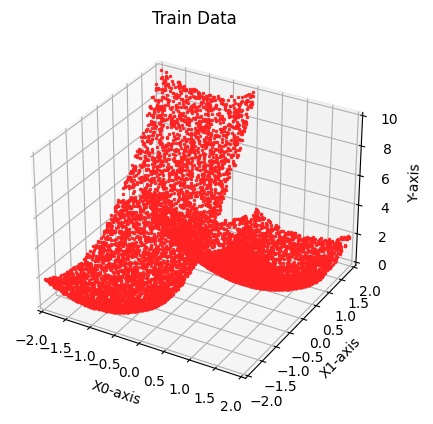

In [6]:
# Pathの設定
if 'google.colab' in sys.modules:
    # マイドライブ内のデータを読み込むpathに設定
    train_path = '/content/drive/MyDrive/train_data.csv'
    test_path = '/content/drive/MyDrive/test_data.csv'
else:
    train_path = 'train_data.csv'
    test_path = 'test_data.csv'

# データの読み込み
with open(train_path) as f:
    reader = csv.reader(f)
    train_data = np.array([[float(x) for x in row] for row in reader])
with open(test_path) as f:
    reader = csv.reader(f)
    test_data = np.array([[float(x) for x in row] for row in reader])

# 訓練データを可視化
plot_data(train_data, 'Train Data')

#### データの数

訓練時とテスト時で扱うデータ数を確認します。

In [7]:
N_train = train_data.shape[0]
print('訓練データの数: ', N_train)
N_test = test_data.shape[0]
print('テストデータの数: ', N_test)

訓練データの数:  10000
テストデータの数:  2000


In [8]:
train_data[:10]

array([[ 0.22754558, -0.33140454,  2.36932388],
       [-0.72463167, -1.97744135,  1.0312193 ],
       [ 0.44369377, -1.3910805 ,  6.02674258],
       [ 1.35287205, -1.8586823 ,  8.2965832 ],
       [ 1.70773382, -0.40463156,  2.47387699],
       [ 0.40668972, -0.90135571,  3.96717063],
       [-1.44760904, -1.50537466,  0.45575741],
       [-1.67322691, -0.99704908,  0.45324318],
       [ 0.2474026 , -1.68761939,  7.78970082],
       [-1.81429888,  0.15576166,  1.99886769]])

### 活性化関数

#### ReLU関数

* <font color="Red">問1. ReLUを完成させてください。</font>

```
引数:
    v: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float)
```

- 以下の式で定義されるrelu関数を実装します。
$$ \text{ReLU}(x) = \left\{ \begin{array}{ll} x & (x \gt 0) \\ 0 & (x \leq 0) \end{array} \right. $$
- 引数`v`の各要素と0の大きい方を取り、`x`とします。
- ヒント: np.maximum()

In [9]:
def relu(v):
    x =  np.maximum(v, 0)
    return x

#### softmax関数
* <font color="Red">問2. softmax関数を完成させてください。</font>

```
引数:
    x: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float)
```

バッチ計算が可能なsoftmax関数を実装します。<br>
exp関数がオーバーフローすることを防ぐために、各データについて入力信号の最大値を引いて、0以下にします。<br>
    numpyでは```[N, M] - [N]```の計算はブロードキャストができませんので、```x```を転置し```[M, N] - [N]```の形で計算を行ったあと、さらに転置をして元の形に戻します。
$$ \text{Softmax}(x_{ij}) = \frac{\exp (x_{ij}^{\prime})}{\sum_{k}^{M}\exp (x_{ik}^{\prime})} \\ $$
$$    x_{ij}^{\prime} = x_{ij} - max_{j}(x_{ij}) $$

In [10]:
# 作業用コード
x = np.array([[1,3], [4,2], [0,5]])
print(x)
y = np.max(x,axis=1)
print(y)

[[1 3]
 [4 2]
 [0 5]]
[3 4 5]


In [28]:
# 作業用コード
x = x.T
print(x-y)
print((x-y).T)

[[-2  0 -5]
 [ 0 -2  0]]
[[-2  0]
 [ 0 -2]
 [-5  0]]


In [11]:
def softmax(x):
    x = x.T
    x = x - np.max(x, axis=0)
    x = np.exp(x)/ np.sum(np.exp(x), axis=0)
    return x.T

#### sigmoid関数
* <font color="Red">問3. sigmoid関数を完成させてください。</font>

```
引数:
    x: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float)
```

バッチ計算が可能なsigmoid関数を実装します。<br>

$$   \text{Sigmoid}(x) = \frac{1}{1 + \exp(-x)} $$

In [87]:
# float型に注意
def sigmoid(x):
    return  1 / (1 + np.exp(-x))

#### tanh関数
* <font color="Red">問4. tanh関数を完成させてください。</font>
  * <font color="Red">問4-1. tanh関数の分子にあたるsinh(双曲線正弦関数)の式を記述しましょう。</font>
  * <font color="Red">問4-2. tanh関数の分母にあたるcosh(双曲線余弦関数)の式を記述しましょう。</font>

```
引数:
    x: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float)
```

バッチ計算が可能なtanh関数を実装します。<br>
tanh関数は以下のように定義されている。<br>

$$   \text{tanh}(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)} $$

tanh関数はハイパボリックタンジェントやタンエイチと読み、sinh関数とcosh関数を用いて以下のように書き直すことができる。

$$   \text{tanh}(x) = \frac{\text{sinh}(x) }{\text{cosh}(x) } $$

sinh関数はハイパボリックサインやシャイン、cosh関数はハイパボリックコサインやコッシュと読み、以下のように定義されている。

$$   \text{sinh}(x) = \frac{\exp(x) - \exp(-x)}{2} $$

$$   \text{cosh}(x) = \frac{\exp(x) + \exp(-x)}{2} $$

In [15]:
def tanh(x):
    sinh =  (np.exp(x) - np.exp(-x)) / 2
    cosh =  (np.exp(x) - np.exp(-x)) / 2
    return sinh / cosh

#### Leaky ReLU関数

* <font color="Red">問5. Leaky ReLUを完成させてください。</font>

```
引数:
    x: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float)
```

- 以下の式で定義されるLeaky ReLU関数を実装します。

$$ \text{Leaky ReLU}(x,\alpha) = \left\{ \begin{array}{ll} x & (x \gt 0) \\ \alpha x & (x \leq 0) \end{array} \right. $$
- $\alpha$は定数。

In [16]:
def lrelu(x, alpha=0.01):
    x =  np.where(x>=0,x,alpha * x)
    return x

#### コスト関数 平均二乗誤差
以下の式で定義される平均二乗誤差を実装します。出題範囲ではないですが、確認しておいてください。
```
引数:
    t: [N, M] (np.float)
    y: [N, M] (np.float)
       Nはバッチサイズにあたる
返値:
    mse: [M] (np.float)
```


$$
\text{MSE} = \frac{1}{NM} \sum_{i}^{N}\sum_{j}^{M} (t_{ij}-y_{ij})^2
$$
- `t`と`y`の差の2乗の平均を取り、`mse`とします。
- 今回のように、M=1（目的変数が一つ）である場合が多い

In [17]:
def MSE(t, y):
    mse = np.mean(np.square(t - y))
    return mse

#### 多層パーセプトロンの定義

<font color="Red">問6-1~問6-4. MLPクラスの順伝播forward関数を完成させてください。</font>
- 以下の式で定義される順伝播を実装します。(Φは活性化関数)
$$
X_{i+1} = \phi(X_i \cdot W_i + B_i)
$$    
- 第1層`self.layer1`を定義します。入力層`self.layer0`と重み`self.w1`との行列積を取り、バイアス`self.b1`を加算します。そして活性化関数`relu`に渡します。
- 第2層`self.layer2`を定義します。第1層`self.layer1`と重み`self.w2`との行列積を取り、バイアス`self.b2`を加算します。そして活性化関数`relu`に渡します。
- 第3層`self.layer3`を定義します。第2層`self.layer2`と重み`self.w3`との行列積を取り、バイアス`self.b3`を加算します。そして活性化関数`relu`に渡します。
- 出力層`self.out`を定義します。第3層`self.layer3`と重み`self.w4`との行列積を取り、バイアス`self.b4`を加算します。
- 出力層では活性化関数Φは使用しないことに注意せよ
- ヒント: np.dot()　もしくは np.matmul()

<font color="Red"> 問6-5~問6-8. MLPクラスの逆伝播によって誤差と勾配を求めるbackward関数を完成させてください。</font>
- 出力層誤差`delta4`を定義します。二乗誤差の微分なので、以下の式に従います。  <br>
$$
\delta_{out} = \frac{d(T-Y)^2}{dY} = -2(T-Y)
$$　
- 誤差逆伝播は以下の式に従います。
$$
\delta_i = \phi'(v_{i+1})*\delta_{i+1} \cdot W_{i+1}^t
$$
$$
\phi'(v_i) = \left\{ \begin{array}{ll}  \frac{d}{dv_i}v_i & (v_i \gt 0) \\  \frac{d}{dv_i}0 & (v_i \leq 0) \end{array} \right. = 
                \left\{ \begin{array}{ll} 1 & (v_i \gt 0) \\ 0 & (v_i \leq 0) \end{array} \right.
$$
- 第3層誤差`delta3`を定義します。出力層誤差`delta4`と重み`self.w4`の転置との行列積を取ります。
- 第2層誤差`delta2`を定義します。第3層誤差`delta3`と第3層`self.layer3`におけるreluの微分との積をとり、重み`self.w3`の転置との行列積を取ります。
- 第1層誤差`delta1`を定義します。第2層誤差`delta2`と第2層`self.layer2`におけるreluの微分との積をとり、重み`self.w2`の転置との行列積を取ります。
- ヒント: numpy.dot(), numpy.transpose(), numpy.where()
- ヒント: reluの微分は該当する層の各要素が0より大きいものは1, 0以下のものは0としたベクトルに等しい

In [91]:
#　作業コード
layer0 = np.array([1, -2])
w1 = np.random.randn(2, 50) * 0.1
b1 = np.zeros(50, dtype=float)

In [92]:
#　作業コード
y = np.dot(layer0, w1) + b1
y = relu(y)
print(y)
print(y.shape)

[0.13702558 0.         0.         0.34426236 0.40640559 0.
 0.         0.32424178 0.         0.32506574 0.         0.24366608
 0.         0.         0.47414246 0.72439132 0.         0.
 0.         0.07393928 0.         0.         0.         0.
 0.         0.         0.         0.22300114 0.         0.08844045
 0.09223215 0.0351893  0.         0.08984429 0.3911732  0.33542804
 0.         0.18134443 0.         0.         0.02369983 0.07723588
 0.04085873 0.         0.2840141  0.19825945 0.44520883 0.
 0.08261739 0.        ]
(50,)


In [93]:
#　作業コード
delta4 = -20
w4 = np.random.randn(10, 1) * 0.1
delta3 = np.dot(delta4, w4.transpose())
print(delta3)

[[-2.00317877  0.96317569 -1.45532936  0.4642959   2.23715296  3.3581971
   2.01029169 -0.87882389 -1.56617015 -2.16396913]]


In [94]:
#　作業コード
a = np.arange(9).reshape((3, 3,))
print(a)
print(np.where(a<4, -1, 100))

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[ -1  -1  -1]
 [ -1 100 100]
 [100 100 100]]


In [52]:
# 回帰モデル
class MLP_regressor():
    '''
    多層パーセプトロン Multi Layered Perceptron
    構成: [入力層, 第1層, 第2層, 第3層, 出力層]
    ノード数: [2, 50, 50, 10, 1]
    '''

    def __init__(self):
        '''
        コンストラクタ
        パラメータ（重みw, バイアスb）の定義
        第1層重み self.w1: [2, 50] 平均0, 標準偏差0.1の乱数
        第2層重み self.w2: [50, 50] 平均0, 標準偏差0.1の乱数
        第3層重み self.w3: [50, 10] 平均0, 標準偏差0.1の乱数
        第4層重み self.w4: [10, 1] 平均0, 標準偏差0.1の乱数
        
        第1層バイアス self.b1: [50] 要素が全て0
        第2層バイアス self.b2: [50] 要素が全て0
        第3層バイアス self.b3: [10] 要素が全て0
        第4層バイアス self.b4: [1] 要素が全て0
        
        numpyの乱数については以下のページを参照
        https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html
        '''
        
        # 重みの定義
        self.w1 = np.random.randn(2, 50) * 0.1
        self.w2 = np.random.randn(50, 50) * 0.1
        self.w3 = np.random.randn(50, 10) * 0.1
        self.w4 = np.random.randn(10, 1) * 0.1

        # バイアスの定義
        self.b1 = np.zeros(50, dtype=float)
        self.b2 = np.zeros(50, dtype=float)
        self.b3 = np.zeros(10, dtype=float)
        self.b4 = np.zeros(1, dtype=float)

    def forward(self, x):
        '''
        順伝播
        入力 x: [N, 2]
        入力層 self.layer0: [N, 2]
        第1層 self.layer1: [N, 50]
        第2層 self.layer2: [N, 50]
        第3層 self.layer3: [N, 10]
        出力層 self.out: [N, 1]
        '''
        
        self.layer0 = x
        self.layer1 = relu(np.dot(self.layer0,self.w1) + self.b1)
        self.layer2 = relu(np.dot(self.layer1,self.w2) + self.b2)
        self.layer3 = relu(np.dot(self.layer2,self.w3) + self.b3)
        self.out = np.dot(self.layer3, self.w4) + self.b4
        return self.out

    def backward(self, t, y):
        
        '''
        逆伝播
        真の値 t: [N, 1]
        予測値 y: [N, 1]
        
        出力層誤差 delta4: [N, 1]
        第3層誤差 delta3: [N, 10]
        第2層誤差 delta2: [N, 50]
        第1層誤差 delta1: [N, 50]
        
        第4層b勾配 dedb4: [N, 1]
        第3層b勾配 dedb3: [N, 10]
        第2層b勾配 dedb2: [N, 50]
        第1層b勾配 dedb1: [N, 50]
        
        第4層w勾配 dedw4: [N, 10, 1]
        第3層w勾配 dedw3: [N, 50, 10]
        第2層w勾配 dedw2: [N, 50, 50]
        第1層w勾配 dedw1: [N, 2, 50]
        '''
        # 出力層の誤差デルタは二乗誤差の微分
        delta4 = -2 * (t - y)
        # 誤差逆伝播
        delta3 = np.dot(delta4, self.w4.T) 
        delta2 = np.dot(delta3 * (np.where(self.layer3 > 0, 1, 0)), self.w3.T)  
        delta1 = np.dot(delta2 * (np.where(self.layer2 > 0, 1, 0)), self.w2.T)

        # バイアスbのコスト関数eに対する勾配
        self.dedb4 = np.mean(delta4, axis=0)
        self.dedb3 = np.mean(delta3 * (self.layer3 > 0), axis=0)
        self.dedb2 = np.mean(delta2 * (self.layer2 > 0), axis=0)
        self.dedb1 = np.mean(delta1 * (self.layer1 > 0), axis=0)

        # 重みwのコスト関数eに対する勾配
        self.dedw4 = np.dot(self.layer3.T, delta4) / delta4.shape[0]
        self.dedw3 = np.dot(self.layer2.T, delta3 * (self.layer3 > 0)) / delta3.shape[0]
        self.dedw2 = np.dot(self.layer1.T, delta2 * (self.layer2 > 0)) / delta2.shape[0]
        self.dedw1 = np.dot(self.layer0.T, delta1 * (self.layer1 > 0)) / delta1.shape[0]

    def optimize_GradientDecent(self, lr):
        '''
        勾配降下法によるパラメータの更新
        '''
        self.b1 -= lr * self.dedb1
        self.b2 -= lr * self.dedb2
        self.b3 -= lr * self.dedb3
        self.b4 -= lr * self.dedb4

        self.w1 -= lr * self.dedw1
        self.w2 -= lr * self.dedw2
        self.w3 -= lr * self.dedw3
        self.w4 -= lr * self.dedw4

#### 学習

以下ではこれまでで定義した多層パーセプトロンを使用し、データを学習します。
コストが正常に減少し、500epochで0.5以下にまで到達していれば学習は成功していると言えます。

In [53]:
# モデルの定義
model = MLP_regressor()

# 学習率
lr = 0.01
# 学習エポック数
n_epoch = 500

x_train = train_data[:, 0:2]
t_train = train_data[:, 2:3]
x_test = test_data[:, 0:2]
t_test = test_data[:, 2:3]

# n_epoch繰り返す
for n in range(n_epoch):
    # 訓練
    # Chapter02範囲外のため、ミニバッチは使用しない
    y = model.forward(x_train)
    train_loss = MSE(t_train, y)
    model.backward(t_train, y)
    model.optimize_GradientDecent(lr)

    # テスト
    y = model.forward(x_test)
    test_loss = MSE(t_test, y)

    print('EPOCH ', n + 1, ' | TRAIN LOSS ',
          train_loss, ' | TEST LOSS ', test_loss)
regression_loss = test_loss

EPOCH  1  | TRAIN LOSS  13.56353861814502  | TEST LOSS  13.603918830080842
EPOCH  2  | TRAIN LOSS  13.27746136828629  | TEST LOSS  13.327109665728573
EPOCH  3  | TRAIN LOSS  13.004801660862567  | TEST LOSS  13.061736720789922
EPOCH  4  | TRAIN LOSS  12.743470818335016  | TEST LOSS  12.806779725176476
EPOCH  5  | TRAIN LOSS  12.492484890557517  | TEST LOSS  12.561350953837408
EPOCH  6  | TRAIN LOSS  12.250976597386078  | TEST LOSS  12.325212860097361
EPOCH  7  | TRAIN LOSS  12.018689167960348  | TEST LOSS  12.098024319812419
EPOCH  8  | TRAIN LOSS  11.795293817498013  | TEST LOSS  11.879302314559373
EPOCH  9  | TRAIN LOSS  11.580300707380426  | TEST LOSS  11.668578492248868
EPOCH  10  | TRAIN LOSS  11.373237800000599  | TEST LOSS  11.465456321431647
EPOCH  11  | TRAIN LOSS  11.173718714908121  | TEST LOSS  11.269547472922019
EPOCH  12  | TRAIN LOSS  10.981359428470299  | TEST LOSS  11.080486236675865
EPOCH  13  | TRAIN LOSS  10.795807286753039  | TEST LOSS  10.897943572073126
EPOCH  14 

EPOCH  110  | TRAIN LOSS  3.3532761683062877  | TEST LOSS  3.279913451653415
EPOCH  111  | TRAIN LOSS  3.2692415263060264  | TEST LOSS  3.194876226637578
EPOCH  112  | TRAIN LOSS  3.186249030592014  | TEST LOSS  3.110958453962027
EPOCH  113  | TRAIN LOSS  3.104332841656513  | TEST LOSS  3.0281298874397025
EPOCH  114  | TRAIN LOSS  3.023473939324622  | TEST LOSS  2.9465015300468065
EPOCH  115  | TRAIN LOSS  2.9436803323844627  | TEST LOSS  2.8661048167832366
EPOCH  116  | TRAIN LOSS  2.865017889408194  | TEST LOSS  2.787024837914039
EPOCH  117  | TRAIN LOSS  2.7875927751525142  | TEST LOSS  2.709479472502632
EPOCH  118  | TRAIN LOSS  2.7116402398892743  | TEST LOSS  2.633636748456122
EPOCH  119  | TRAIN LOSS  2.6373386003086647  | TEST LOSS  2.5598548200495723
EPOCH  120  | TRAIN LOSS  2.565037317157145  | TEST LOSS  2.4882572111578756
EPOCH  121  | TRAIN LOSS  2.4947980046388403  | TEST LOSS  2.4188104116084226
EPOCH  122  | TRAIN LOSS  2.4266216981357656  | TEST LOSS  2.35150623703292

EPOCH  219  | TRAIN LOSS  0.7661743460156544  | TEST LOSS  0.7600830828969978
EPOCH  220  | TRAIN LOSS  0.7625444760645184  | TEST LOSS  0.7566237495340328
EPOCH  221  | TRAIN LOSS  0.7589600692482176  | TEST LOSS  0.7532022873232247
EPOCH  222  | TRAIN LOSS  0.7554162423873899  | TEST LOSS  0.7498148048204719
EPOCH  223  | TRAIN LOSS  0.7519152936929806  | TEST LOSS  0.7464742073039268
EPOCH  224  | TRAIN LOSS  0.74845925087106  | TEST LOSS  0.7431699868890114
EPOCH  225  | TRAIN LOSS  0.7450447180799059  | TEST LOSS  0.7399049861586757
EPOCH  226  | TRAIN LOSS  0.7416713260715784  | TEST LOSS  0.7366785424583076
EPOCH  227  | TRAIN LOSS  0.7383359847794414  | TEST LOSS  0.733485279417295
EPOCH  228  | TRAIN LOSS  0.7350381186445202  | TEST LOSS  0.7303222737233528
EPOCH  229  | TRAIN LOSS  0.7317772993741175  | TEST LOSS  0.72719119957457
EPOCH  230  | TRAIN LOSS  0.7285524901424798  | TEST LOSS  0.7240913192463989
EPOCH  231  | TRAIN LOSS  0.7253615295484431  | TEST LOSS  0.72102306

EPOCH  328  | TRAIN LOSS  0.5152931293289995  | TEST LOSS  0.5143658240704051
EPOCH  329  | TRAIN LOSS  0.5138900250581042  | TEST LOSS  0.51294798959762
EPOCH  330  | TRAIN LOSS  0.5124984164285843  | TEST LOSS  0.5115422955896205
EPOCH  331  | TRAIN LOSS  0.5111189339612217  | TEST LOSS  0.5101486993123722
EPOCH  332  | TRAIN LOSS  0.5097515420606822  | TEST LOSS  0.5087646733066732
EPOCH  333  | TRAIN LOSS  0.5083957488837537  | TEST LOSS  0.5073915297798158
EPOCH  334  | TRAIN LOSS  0.5070510598480596  | TEST LOSS  0.5060293307788203
EPOCH  335  | TRAIN LOSS  0.5057186410750383  | TEST LOSS  0.5046800335762976
EPOCH  336  | TRAIN LOSS  0.5043962511786179  | TEST LOSS  0.5033393375488132
EPOCH  337  | TRAIN LOSS  0.5030847254997641  | TEST LOSS  0.5020122543833345
EPOCH  338  | TRAIN LOSS  0.5017851271371796  | TEST LOSS  0.5006939821937615
EPOCH  339  | TRAIN LOSS  0.5004969602269804  | TEST LOSS  0.49938821032021463
EPOCH  340  | TRAIN LOSS  0.4992203273702692  | TEST LOSS  0.4980

EPOCH  435  | TRAIN LOSS  0.4148981328017889  | TEST LOSS  0.4114291825256488
EPOCH  436  | TRAIN LOSS  0.4142690675519087  | TEST LOSS  0.41077861096770824
EPOCH  437  | TRAIN LOSS  0.41364289467682175  | TEST LOSS  0.41013295875804023
EPOCH  438  | TRAIN LOSS  0.4130198860946655  | TEST LOSS  0.40949189710141376
EPOCH  439  | TRAIN LOSS  0.4124003129038274  | TEST LOSS  0.4088511499784071
EPOCH  440  | TRAIN LOSS  0.41178412039992707  | TEST LOSS  0.4082164556487925
EPOCH  441  | TRAIN LOSS  0.4111718736029383  | TEST LOSS  0.4075857855617123
EPOCH  442  | TRAIN LOSS  0.4105638571478294  | TEST LOSS  0.40695882650087867
EPOCH  443  | TRAIN LOSS  0.40995949722773073  | TEST LOSS  0.4063338914579859
EPOCH  444  | TRAIN LOSS  0.40935797934713763  | TEST LOSS  0.40571342395084425
EPOCH  445  | TRAIN LOSS  0.40875889415896965  | TEST LOSS  0.40509678319617204
EPOCH  446  | TRAIN LOSS  0.4081624975773951  | TEST LOSS  0.4044817131532835
EPOCH  447  | TRAIN LOSS  0.40756936601845867  | TEST

#### 予測データの散布図

予測値の散布図と訓練データの散布図を比較してみましょう。

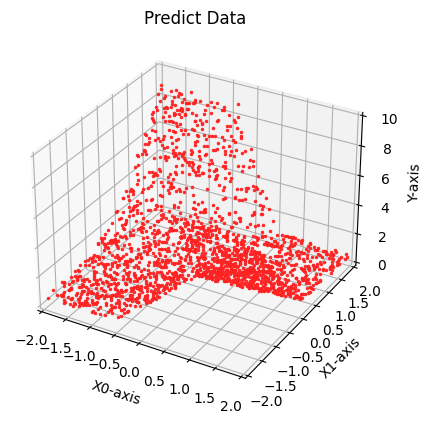

In [97]:
y = model.forward(x_test)
predict_data = np.concatenate([x_test, y], axis=1)
plot_data(predict_data, 'Predict Data')

## 分類モデル演習（スクラッチ）

---

### データ準備

回帰モデル演習では層ごとに変数を定義し全計算を実装しましたが、分類モデル演習ではクラスと計算グラフを利用し、より汎用的なモデルを設計します。

#### データの読み込み
本演習では、MNISTを使用し、全結合ネットワークで手書き数字の画像の10分類を行います。

今回はデータセットとして、"MNIST"を用います。

"MNIST"は0~9の手書き数字が画像になった画像データと書かれた数字の正解ラベルで構成されており、チュートリアルでよく使われています。データセット全体は70000件で構成されています。

`sklearn`の`train_test_split`を用いてMNISTデータを訓練データとテストデータに分割します。

引数`test_size=0.2`と指定することで、訓練データ:テストデータ = 8:2 に分割することが出来ます。

データは 1チャンネル 28×28 の配列となっています。


In [37]:
# mnistデータセットのロード(ネットワーク接続が必要・少し時間がかかります)
if os.path.exists('mnist_784'):
    with open('mnist_784','rb') as f:
        mnist = pickle.load(f)
else:
    mnist = datasets.fetch_openml('mnist_784', as_frame=False)
    with open('mnist_784', 'wb') as f:
        pickle.dump(mnist, f)
        
# 画像とラベルを取得
X, T = mnist.data, mnist.target
# 訓練データとテストデータに分割
X_train, X_test, T_train, T_test = train_test_split(X, T, test_size=0.2)

In [38]:
# ラベルデータをint型にし、one-hot-vectorに変換します
T_train = np.eye(10)[T_train.astype("int")]
T_test = np.eye(10)[T_test.astype("int")]

#### one-hot-vectorとは？
たとえば$a$が，0~9の整数のみを含むベクトルだとわかっている時に、各要素を数字に該当する列の要素のみが1、その他が0となるようなベクトルにする。
$$
\begin{equation*}
a=
\begin{pmatrix}
1\\
8\\
4\\
2\\
0
\end{pmatrix}\to
a\_onehot = 
\begin{pmatrix}
0, 1, 0, 0, 0, 0, 0, 0, 0, 0\\
0, 0, 0, 0, 0, 0, 0, 0, 1, 0\\
0, 0, 0, 0, 1, 0, 0, 0, 0, 0\\
0, 0, 1, 0, 0, 0, 0, 0, 0, 0\\
1, 0, 0, 0, 0, 0, 0, 0, 0, 0
\end{pmatrix}
\end{equation*}
$$
学習する正解ラベルデータは，one-hot-vectorで表されることが多い．

#### データの構造
データ数、画像データXの形、ラベルTの形などを調べます。

In [39]:
print('訓練データの画像の形:', X_train.shape)
print('テストデータの画像の形:', X_test.shape)

print("\n"'訓練データのラベルTの形:', T_train.shape)
print('テストデータのラベルTの形:', T_test.shape)

訓練データの画像の形: (56000, 784)
テストデータの画像の形: (14000, 784)

訓練データのラベルTの形: (56000, 10)
テストデータのラベルTの形: (14000, 10)


#### データのサンプリング
画像・ラベルデータをランダムにいくつか取り出して可視化します。
画像は784要素の1次元ベクトルとしてXに格納されていますが、画像として表示するときは28x28の二次元にreshapeします。

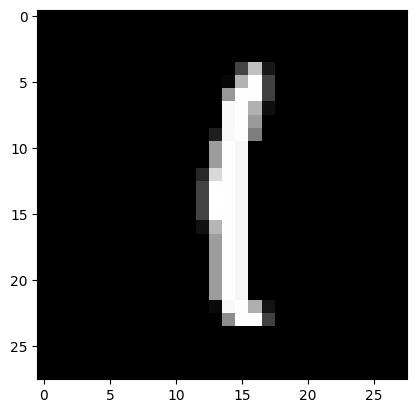

Label:  1


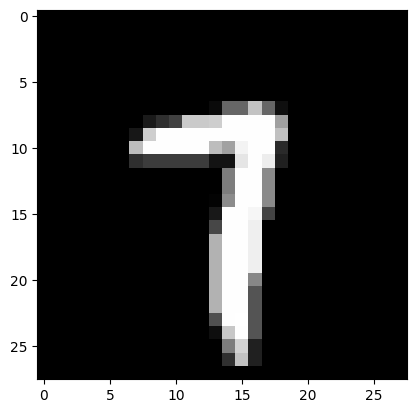

Label:  7


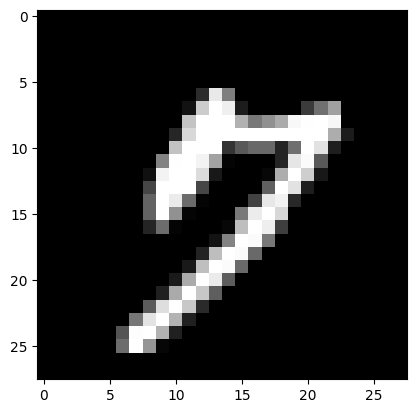

Label:  7


In [101]:
# テストデータをランダムサンプリング
perm = np.random.permutation(len(X_test))
# サンプル画像を表示する
plt.gray()
for i in perm[:3]:
    plt.imshow(X_test[perm[i]].reshape(28, 28))
    plt.show()
    print('Label: ', np.argmax(T_test[perm[i]]))

### 多層パーセプトロンの定義

#### クロスエントロピー誤差
以下の式で定義される平均二乗誤差を実装します。出題範囲ではないですが、確認しておいてください。<br>
```
引数:
    t: [N, M] (np.float)
    y: [N, M] (np.float)
返値:
    error: (np.float)
```

```y == 0```のときlog関数が破綻しないよう、$ y $ に小さな値 $ \delta = 10^{-8}$ を加算します。
error は 以下の式に従います。
$$ error = -\frac {1}{N} \sum_{i}^{N} {t_i * \log{(y_i + \delta)}} $$

In [40]:
def cross_entropy_error(t, y):
    delta = 1e-8
    batch_size = t.shape[0]
    error = -np.sum(t * np.log(y + delta)) / batch_size
    return error

#### ソフトマックスクロスエントロピー誤差
ソフトマックスクロスエントロピー誤差のクラスを実装します。出題範囲ではないですが、確認しておいてください。<br>
順伝播```__call__(self, t, y)```ではyのソフトマックスを取り、tとのクロスエントロピー誤差を返します。その際にyとtをインスタンス変数self.yとself.tに記憶します。関数名を```__call__```としているのは、**関数オブジェクト**を作ることで"インスタンス名()"で順伝播を呼び出せるようにするためです。<br>
逆伝播```backward(self)```では、順伝播で記憶されたself.yとself.tを使用して誤差に対するyの勾配dyを計算します。<br>
yの勾配は以下の式に従います。<br>
※コードの```dy```と式の$ dy $は意味が異なり、```dy``` = $ \frac {dL(t, y)}{dy} $であることに注意してください。
$$ \frac {dL(t, y)}{dy} = y - t $$
また、以降の計算ではバッチの平均を取るため、dyはバッチサイズで割ってから返します。

In [41]:
class SoftmaxCrossEntropyLoss():
    def __init__(self):
        self.y = None
        self.t = None
        self.loss = None
        
    def __call__(self, t, y):
        self.y = softmax(y)
        self.t = t.copy()
        self.loss = cross_entropy_error(self.t, self.y)
        return self.loss
    
    def backward(self):
        batch_size = self.t.shape[0]
        dy = self.y - self.t
        dy /= batch_size
        return dy

#### 全結合層

```
インスタンス変数:
    self.w: [M, L] (np.float)
            層の重み。正規分布で初期化。
    self.b: [L] (np.float)
            層のバイアス。ゼロで初期化。
    self.x: [N, M] (np.float)
            層の入力信号を記録。Nはバッチサイズ。
    self.dw: [M, L] (np.float)
            層の重みの勾配
    self.db: [L] (np.float)
            層のバイアスの勾配
            
__call__(self, x):
    引数:
        x: [N, M] (np.float)
            入力信号
    返値:
        out: [N, L] (np.float)
            出力信号

backward(self, dout):
    引数:
        dout: [N, L] (np.float)
            出力信号の勾配
    返値:
        dx: [N, M] (np.float)
            入力信号の勾配
        
```
順伝播```__call__(self, x)```は入力信号xを層の重み```self.w```とバイアス```self.b```でアフィン変換し出力とします。
計算は以下の式に従います。
$$ \text{Affine}(x) = out = x \cdot w + b $$
逆伝播```backward(self, dout)```は出力側の勾配[L, M]を入力側に逆伝播させます。入力の勾配```dx```、重みの勾配```dw```、バイアスの勾配```db```それぞれを計算し、```dx```を返します。
計算は以下の式に従います。

$$ 
\begin{align}
\text{grad}(x_{ij}) &= \sum_{k} \text{grad}(out_{ik}) \frac{dout_{ik}}{dx_{ij}} \\
\text{grad}(x_{ij}) &= \sum_{k}\text{grad}(out_{ik})w_{jk} \\
\text{grad}(x) &= \text{grad}(out) \cdot w^T \\ \space \\
\end{align}
$$ 

$$ 
\begin{align}
\text{grad}(w_{jk}) &= \sum_{i} \text{grad}(out_{ik}) \frac{dout_{ik}}{dw_{jk}} \\
\text{grad}(w_{jk}) &= \sum_{i} \text{grad}(out_{ik})x_{ij} \\
\text{grad}(w) &= x^T \cdot \text{grad}(out) \\ \space \\
\end{align}
$$

$$ 
\begin{align}
\text{grad}(b_{k}) &= \sum_{i} \text{grad}(out_{ik}) \frac{dout_{ik}}{db_{k}} \\
\text{grad}(b) &= \sum_{i} \text{grad}(out_{i}) 
\end{align}
$$


    
実装コードでは$ \text{grad}(x) $ = ```dx```, $ \text{grad}(w) $ = ```dw```, $ \text{grad}(b) $ = ```db```と命名されています。 

* <font color="Red">問7. 全結合層クラスを完成させてください。</font>
  * <font color="Red">問7-1. self.x, self.w, self.bの3つの変数を用いて順伝播の出力式を記述してください。</font>
  * <font color="Red">問7-2. 出力信号の勾配doutとself.wを用いて入力信号の勾配を算出する式を記述しましょう。</font>
  * <font color="Red">問7-3. 逆伝播に使う勾配self.dwを算出する式を記述しましょう。</font>
  * <font color="Red">問7-4. 逆伝播に使う勾配self.dbを算出する式を記述しましょう。</font>

In [42]:
class FullyConnectedLayer():
    def __init__(self, input_shape, output_shape):
        self.w = np.random.randn(input_shape, output_shape) * 0.01
        self.b = np.zeros(output_shape, dtype=np.float64)
        self.x = None
        self.dw = None
        self.db = None
        
    def __call__(self, x):
        self.x = x
        out =  np.dot(x,self.w) + self.b 
        return out
    
    def backward(self, dout):
        dx =  np.dot(dout, self.w.T)
        self.dw = np.dot(self.x.T, dout) 
        self.db = np.sum(dout, axis=0)
        return dx

#### ReLUクラス

```
インスタンス変数:
    self.mask: [N, M] np.bool
               マスクされるxのフラッグ
               
__call__(self, x):
    引数:
        x: [N, M] np.float
    返値:
        out: [N, M] np.float

backward(self, dout):
    引数:
        dout: [N, M] np.float
    返値:
        dx: [N, M] np.float
    
```

ReLUの順伝播と逆伝播をクラスで実装します。
順伝播```__call__(self, x)```は入力信号xに対して、```x <= 0```部分が1、それ以外は0となるような行列self.maskを定義します。numpy配列の**ブールインデックス参照**を利用し、xのマスク部を0に変換し返します。
逆伝播```backward(self, dout)```は出力信号の勾配doutの保存されたマスク部を0に変換し、dxとして入力信号の勾配を返します。

* <font color="Red">問8. ReLUクラスを完成させてください。</font>
  * <font color="Red">問8-1. マスク部のフラグであるself.maskを用いて、xのマスク部を0に変換する式を記述しましょう。</font>
  * <font color="Red">問8-2. マスク部のフラグであるself.maskを用いて、出力信号の勾配doutのマスク部を0に変換する式を記述しましょう。</font>

In [26]:
# 作業コード
x = np.array([-3.5, 1.5, 0, 7, -9, 10, 2, 12, -0.1])
print(x)

[-3.5  1.5  0.   7.  -9.  10.   2.  12.  -0.1]


In [27]:
# 作業コード
mask = (x <= 0)
print(mask)

[ True False  True False  True False False False  True]


In [28]:
# 作業コード
x[mask] = 0
print(x)

[ 0.   1.5  0.   7.   0.  10.   2.  12.   0. ]


In [43]:
class ReLU():
    def __init__(self):
        self.mask = None

    def __call__(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

#### Sigmoidクラス

```
インスタンス変数:
    self.out: [N, M] np.float
               
__call__(self, x):
    引数:
        x: [N, M] np.float
    返値:
        out: [N, M] np.float

backward(self, dout):
    引数:
        dout: [N, M] np.float
    返値:
        dx: [N, M] np.float
    
```

Sigmoidの順伝播と逆伝播をクラスで実装します。
順伝播```__call__(self, x)```
は入力信号xに対して、```sigmoid(x)```計算します。\
逆伝播```backward(self, dout)```は出力信号の勾配doutに対して、以下の計算を施すことでdxとして入力信号の勾配を返します。
$$ \frac {dL}{dx} = \frac {dL}{dy} y(1-y)$$

* <font color="Red">問9. Sigmoidクラスを完成させてください。</font>
  * <font color="Red">問9-1. 問3で実装したsigmoid関数を用いて、入力信号xに対してsigmoid(x)を記述しましょう。</font>
  * <font color="Red">問9-2. 出力信号の勾配doutとSigmoid関数の勾配(上式)を用いて、入力信号の勾配dxを記述しましょう。</font>

In [44]:
class Sigmoid():
    def __init__(self):
        self.out = None

    def __call__(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

#### Tanhクラス

```
インスタンス変数:
    self.out: [N, M] np.float
               
__call__(self, x):
    引数:
        x: [N, M] np.float
    返値:
        out: [N, M] np.float

backward(self, dout):
    引数:
        dout: [N, M] np.float
    返値:
        dx: [N, M] np.float
    
```

Tanhの順伝播と逆伝播をクラスで実装します。
順伝播```__call__(self, x)```
は入力信号xに対して、```tanh(x)```計算します。\
逆伝播```backward(self, dout)```は出力信号の勾配doutに対して、以下の計算を施すことでdxとして入力信号の勾配を返します。
\begin{align}
\frac {dL}{dx} &= \frac {dL}{dy} \frac {4}{(e^x + e^{-x})^2}\\
&=\frac {dL}{dy} \frac {1}{\text{cosh}^2x}
\end{align}

ここでは、$ \text{cosh} x$という関数が使われているが、ハイパボリックコサインといい。双曲線関数の1つで以下のような関数である。
$$ \text{cosh} x = \frac {e^x + e^{-x}}{2}$$ 

* <font color="Red">問10. Tanhクラスを完成させてください。</font>
  * <font color="Red">問10-1. 問4で実装したtanh関数を用いて、入力信号xに対してtanh(x)を記述しましょう。</font>
  * <font color="Red">問10-2. 出力信号の勾配doutとTanh関数の勾配(上式)を用いて、入力信号の勾配dxを記述しましょう。</font>

In [58]:
class Tanh():
    def __init__(self):
        self.out = None

    def __call__(self, x):
        out = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        self.x = x
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1 / (cosh**2))

        return dx

#### Leaky ReLUクラス

```
インスタンス変数:
    self.mask: [N, M] np.bool
               マスクされるxのフラッグ
               
__call__(self, x, alpha=0.01):
    引数:
        x: [N, M] np.float
    返値:
        out: [N, M] np.float

backward(self, dout):
    引数:
        dout: [N, M] np.float
    返値:
        dx: [N, M] np.float
    
```

Leaky ReLUの順伝播と逆伝播をクラスで実装します。
順伝播```__call__(self, x)```は入力信号xに対して、```x <= 0```部分が1、それ以外は0となるような行列self.maskを定義します。numpy配列の**ブールインデックス参照**を利用し、xのマスク部にalphaを掛け算を施します。
逆伝播```backward(self, dout)```は出力信号の勾配doutの保存されたマスク部にalphaを掛け、dxとして入力信号の勾配を返します。

* <font color="Red">問11. Leaky ReLUクラスを完成させてください。</font>
  * <font color="Red">問11-1. マスク部のフラグであるself.maskを用いて、xのマスク部をalpha倍する式を記述しましょう。</font>
  * <font color="Red">問11-2. マスク部のフラグであるself.maskを用いて、出力信号の勾配doutのマスク部をalpha倍する式を記述しましょう。</font>

In [56]:
class Leaky_ReLU():
    def __init__(self, alpha=0.01):
        self.mask = None
        self.alpha = alpha

    def __call__(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = self.alpha * out[self.mask]
        return out

    def backward(self, dout):
        dout[self.mask] = self.alpha * dout[self.mask]
        dx = dout

        return dx

問題は以上になります。以下のモデルの構築と学習で実装が正しいことを確認しましょう。

#### モデルの構築

これまで各種の層をクラスで定義できましたので、ここではそれらを組み合わせることでモデルを簡単に設計することができます。問題にはなっていませんが、コードからモデルの構築の全体像を把握しましょう。

In [57]:
class MLP_classifier():

    def __init__(self):
        '''
        構造
        x -> fc(784, 256) -> relu -> fc(256, 256) -> relu -> fc(256, 10) -> out
        '''
        
        # 層の定義
        self.fc1 = FullyConnectedLayer(784, 256)
        self.relu1 = ReLU()
        self.fc2 = FullyConnectedLayer(256, 256)
        self.relu2 = ReLU()
        self.fc3 = FullyConnectedLayer(256, 10)
        self.out = None
        
        # 損失関数の定義
        self.criterion = SoftmaxCrossEntropyLoss()

    def forward(self, x):
        '''
        順伝播
        '''
        
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        self.out = self.fc3(x)
        
        # 勾配計算の都合上softmaxはこの順伝播関数内では行わない
        # 予測するときはさらにsoftmaxを通す必要がある
        return self.out

    def backward(self, t):
        '''
        逆伝播
        '''
        
        # 誤差を計算
        loss = self.criterion(t, self.out)
        # 勾配を逆伝播
        d = self.criterion.backward()
        d = self.fc3.backward(d)
        d = self.relu2.backward(d)
        d = self.fc2.backward(d)
        d = self.relu1.backward(d)
        d = self.fc1.backward(d)
        
        return loss

    def optimize_GradientDecent(self, lr):
        '''
        勾配降下法による全層のパラメータの更新
        '''
        for fc in [self.fc1, self.fc2, self.fc3]:
            fc.w -= lr * fc.dw
            fc.b -= lr * fc.db
        

#### 学習

20epochで分類精度が80%以上になっていれば学習は成功していると言えます。

In [49]:
# モデルの宣言
model = MLP_classifier()

# 学習率
lr = 0.005
# 学習エポック数
n_epoch = 20

# n_epoch繰り返す
for n in range(n_epoch):
    # 訓練
    # Chapter02範囲外のため、ミニバッチは使用しない
    y = model.forward(X_train)
    loss = model.backward(T_train)
    model.optimize_GradientDecent(lr)
    
    # テスト
    y = model.forward(X_test)
    test_loss = model.backward(T_test)
    pred = softmax(y)
    accuracy = np.mean(np.equal(np.argmax(y, axis=1), np.argmax(T_test, axis=1)))
    print(f'EPOCH {n + 1} | TRAIN LOSS {loss:.5f} | TEST LOSS {test_loss:.5f} | ACCURACY {accuracy:.2%}')
classification_accuracy = accuracy

EPOCH 1 | TRAIN LOSS 2.37964 | TEST LOSS 2.22899 | ACCURACY 24.54%
EPOCH 2 | TRAIN LOSS 2.23043 | TEST LOSS 2.13971 | ACCURACY 36.21%
EPOCH 3 | TRAIN LOSS 2.13877 | TEST LOSS 2.05365 | ACCURACY 46.10%
EPOCH 4 | TRAIN LOSS 2.05127 | TEST LOSS 1.96469 | ACCURACY 54.17%
EPOCH 5 | TRAIN LOSS 1.96139 | TEST LOSS 1.87078 | ACCURACY 59.46%
EPOCH 6 | TRAIN LOSS 1.86682 | TEST LOSS 1.77163 | ACCURACY 63.04%
EPOCH 7 | TRAIN LOSS 1.76722 | TEST LOSS 1.66824 | ACCURACY 65.94%
EPOCH 8 | TRAIN LOSS 1.66362 | TEST LOSS 1.56272 | ACCURACY 68.41%
EPOCH 9 | TRAIN LOSS 1.55802 | TEST LOSS 1.45780 | ACCURACY 70.49%
EPOCH 10 | TRAIN LOSS 1.45316 | TEST LOSS 1.35638 | ACCURACY 72.47%
EPOCH 11 | TRAIN LOSS 1.35188 | TEST LOSS 1.26099 | ACCURACY 74.16%
EPOCH 12 | TRAIN LOSS 1.25666 | TEST LOSS 1.17343 | ACCURACY 75.54%
EPOCH 13 | TRAIN LOSS 1.16930 | TEST LOSS 1.09460 | ACCURACY 76.92%
EPOCH 14 | TRAIN LOSS 1.09068 | TEST LOSS 1.02456 | ACCURACY 78.00%
EPOCH 15 | TRAIN LOSS 1.02085 | TEST LOSS 0.96285 | ACCUR

#### 提出可否

In [54]:
print("大問1 回帰ロス: ", regression_loss)
print("大問2 分類精度: ", classification_accuracy)
pass0 = regression_loss < 0.5
pass1 = classification_accuracy > 0.8
if pass0 and pass1:
    print("回帰モデルと分類モデルどちらも学習が成功しているので、提出可能です。")
else:
    if not pass0:
        print("回帰モデル（大問１）の学習が成功していません。")
    if not pass1:
        print("分類モデル（大問２）の学習が成功していません。")
    print("回答を訂正してください。")

大問1 回帰ロス:  0.3753669945921212
大問2 分類精度:  0.8235714285714286
回帰モデルと分類モデルどちらも学習が成功しているので、提出可能です。


#### 補足

今演習では簡単のため、ミニバッチ学習・重み減衰などの正則化・より高度な最適化・データのオーグメンテーション(拡張)など、chapter03, chapter04で学習する重要な手法を使用していません。これらを使用すれば、全結合層でもmnist手書き数字の認識精度を大きく上げることが可能です。例えばミニバッチを簡単に導入するだけで、20epochで97%以上の精度に達します。

#### 発展

回帰モデル演習、分類モデル演習それぞれについて学習率・エポック数を変えてみて学習における挙動を観察してみましょう。また、多層パーセプトロンの総数やノード数を変更し、より良い精度を出せる条件を探してみましょう。